<h1 align="center"> User viability </h1>

## 1. Business Understanding

In this kernel we will use various predictive models to see how accurate they  are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!

### Our Goals: 

* Understand the little distribution of the "little" data that was provided to us. </li>
* Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm) </li>
* Determine the Classifiers we are going to use and decide which one has a higher accuracy. </li>
* Create a Neural Network and compare the accuracy to our best classifier. </li>

<h2> Outline: </h2>
I. <b>Understanding our data</b><br>
a) [Gather Sense of our data](#gather)<br><br>

II. <b>Preprocessing</b><br>
a) [Scaling and Distributing](#distributing)<br>
b) [Splitting the Data](#splitting)<br><br>

III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>
b) [Anomaly Detection](#anomaly)<br>
c) [Dimensionality Reduction and Clustering (t-SNE)](#clustering)<br>
d) [Classifiers](#classifiers)<br>
e) [A Deeper Look into Logistic Regression](#logistic)<br>
f) [Oversampling with SMOTE](#smote)<br><br>

IV. <b>Testing </b><br>
a) [Testing with Logistic Regression](#testing_logistic)<br>
b) [Neural Networks Testing (Undersampling vs Oversampling)](#neural_networks)



## 2. Data Understanding
<a id="gather"></a>
The first thing we must do is gather a <b> basic sense </b> of our data. Remember, except for the <b>transaction</b> and <b>amount</b> we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

SEED = 42

c:\Users\user\.virtualenvs\habi_ia-jg5KU8bY\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
habi_df = pd.read_excel('dataset.xlsx')

In [3]:
habi_df.head()

,id,birth_date,terms_conditions,gender,meta,date_exp_token,id.1,contact_id,type_occupation_id,type_independent_activity_id,...,company_phone,company_city_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,23963,1984-07-08,0,NaN,NaN,2023-01-16 18:16:50.0,4547,23963,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,23965,1985-02-14,0,NaN,NaN,NaN,4549,23965,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,24370,1997-01-09,0,NaN,NaN,NaN,4860,24370,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


In [4]:
print(habi_df.shape)
print(habi_df.columns)

(3944, 33)
Index(['id', 'birth_date', 'terms_conditions', 'gender', 'meta',
       'date_exp_token', 'id.1', 'contact_id', 'type_occupation_id',
       'type_independent_activity_id', 'type_profession_id',
       'type_contract_id', 'init_occupation_date', 'incomes', 'extra_incomes',
       'familiar_debts', 'is_tax_return', 'loan_required', 'defer_years',
       'region_id', 'company_nit', 'company_name', 'company_address',
       'company_phone', 'company_city_id', 'name', 'label', 'is_active',
       'activity_code', 'name.1', 'label.1', 'viability', 'is_selected'],
      dtype='object')


### Data Content

**Nota:** Las siguientes definiciones estan basadas en la información que aparentemente tiene nuestro dataset. Sin embargo puede que estas no sean acertadas y se deba consultar a los stakeholders respectivos para una definicion mucho mas acertada. Sin embargo estas son significativas como punto de partida para el analisis posterior.


**id:** ID del usuario

**birth_date:** Fecha de nacimiento del usuario

**terms_conditions:** Indica si el usuario aceptó los términos y condiciones

**gender:** Género del usuario

**meta:** Metadatos asociados a una transacción

**date_exp_token:** Fecha de expiración del token

**id.1**: ID de la ocupación del usuario

**contact_id:** ID del usuario - duplicado con "id

**type_occupation_id:** Tipo de ocupación del usuario

**type_independent_activity_id:** ID del tipo de actividad independiente

**type_profession_id:** ID del tipo de profesión

**type_contract_id:** ID del tipo de contrato

**init_occupation_date:** Fecha de inicio de la ocupación

**incomes:** Ingresos totales

**extra_incomes:** Ingresos extra

**familiar_debts:** Deudas relacionadas con la familia del usuario

**is_tax_return:** Indica si corresponde una declaración de impuestos

**loan_required:** Indica si se requiere un préstamo

**defer_years:** Número de años para los cuales se pospone el préstamo

**region_id:** ID de la región

**company_name:** Nombre de la empresa

**company_nit:** NIT (Número de Identificación Tributaria) 

**company_address:** Dirección de la empresa

**company_phone:** Número de teléfono de la empresa

**company_city_id:** ID de la ciudad donde se encuentra la empresa

**name:** nombre del reporte en ingles

**label:** nombre del reporte en español (duplicado con name)

**is_active:** Indica si el usuario está activo

**activity_code:** Código relacionado con una actividad específica

**name.1** : tipo de trabajo del usuario en ingles

**label.1** :tipo de trabajo del usuario en español (duplicado con name.1)

**viability:** Si el usuario es viable o no

**is_selected:** Si el usuario es seleccionado o no


In [5]:
habi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944 entries, 0 to 3943
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3944 non-null   int64  
 1   birth_date                    3900 non-null   object 
 2   terms_conditions              3944 non-null   int64  
 3   gender                        2 non-null      object 
 4   meta                          16 non-null     object 
 5   date_exp_token                2351 non-null   object 
 6   id.1                          3944 non-null   int64  
 7   contact_id                    3944 non-null   int64  
 8   type_occupation_id            3944 non-null   int64  
 9   type_independent_activity_id  3944 non-null   int64  
 10  type_profession_id            2 non-null      float64
 11  type_contract_id              0 non-null      float64
 12  init_occupation_date          2 non-null      object 
 13  inc

### Distribucion de nuestra variable objetivo

**Nota:** El dataset esta desbalanceado, hay aproximadamente dos veces mas registros en la clase 1 que en la clase 2. Con este contexto abordaremos este aspecto con 2 enfoques:

1) Usando Undersampling 
2) Usando una metrica que sea resistente a clases imbalanceadas

<Axes: xlabel='viability', ylabel='count'>

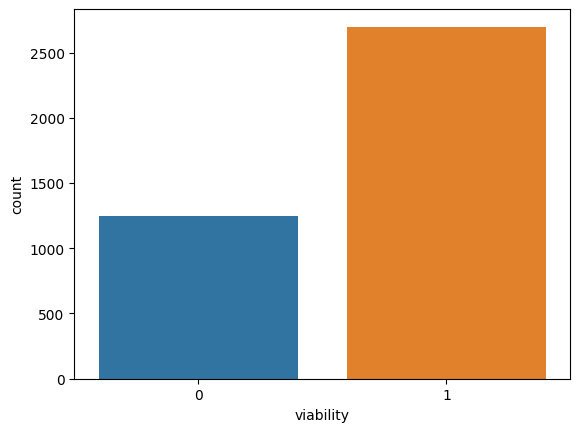

In [6]:
sns.countplot(x=habi_df['viability'])

### Examinando valores nulos 

**Nota:** El mapa de calor denota unos detalles importantes
1) Hay varias columnas que estan completamente llenas de valores nulos, estas se deben eliminar
2) Hay columnas que estan parcialmente nulas, mas adelante mostrare como tratar con estas columnas y como estos valores nulos tambien nos pueden aportar informacion a nuestro ejercicio.
3) Hay columnas que estan completas, mas sin embargo hay unas que no seran utiles para nuestro ejercicio, otras tienen valores constantes o repetidos con otras columnas.

<Axes: >

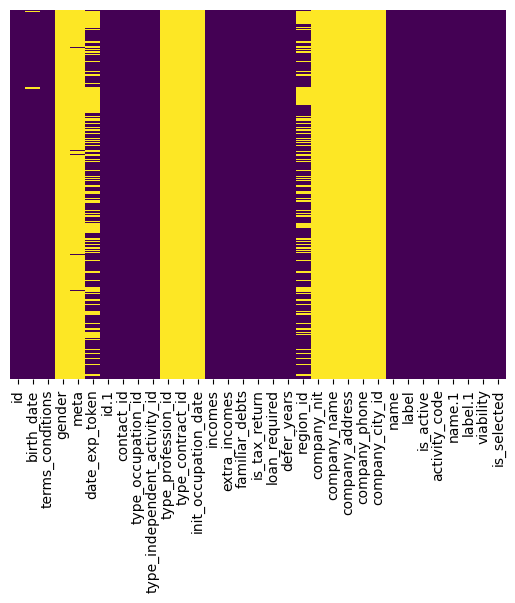

In [7]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

* 1) Columnas completamente nulas 
`gender`,`meta`,`type_profession_id`,`type_contract_id`,`init_occupation_date`,`company_nit`,`company_name`,`company_address`,`company_phone`,`company_city_id`

* 2. Columnas parcialmente vacias

`date_exp_token`: Los campos de las fechas son similares a las fechas alrededor, esto es un buen patron, podriamos usar las fechas cercanas para llenar esta informacion nula, y crear una nueva variable `has_date_exp_token` para recordar sin esta columnas tenia un valor nulo

In [8]:
habi_df[['date_exp_token']].head(10)

,date_exp_token
0,2022-11-25 23:13:29.0
1,2022-11-25 23:13:29.0
2,2023-01-16 18:16:50.0
3,NaN
4,NaN
5,2023-01-23 16:34:06.0
6,2023-03-08 16:25:17.0
7,2023-03-08 16:25:17.0
8,2023-03-08 16:25:17.0
9,2023-04-05 17:05:16.0


`region_id`: Mas de 1000 datos son nulos, y otras categorias se repiten con muy poca frecuencia, una forma de abordar este caso es cambiar los valores nulos con 0, los valores que sean muy poco comunes con -1. Ademas de ello crear una nueva columna `has_region_id` para recordar si habia o no un valor nulo 

<Axes: xlabel='region_id'>

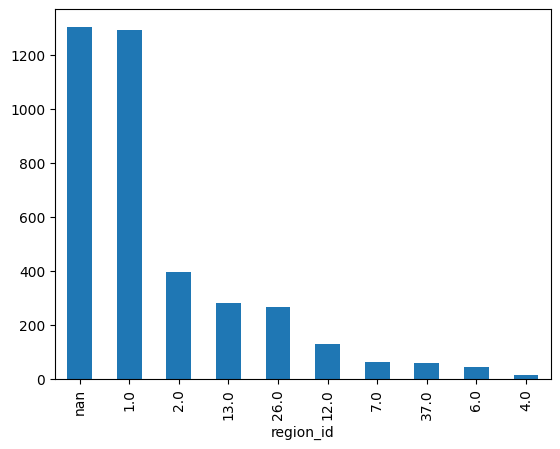

In [9]:
habi_df['region_id'].value_counts(dropna=False).head(10).plot.bar()

* 3.a  Columnas repetidas

In [10]:
habi_df[['name','label']].groupby(['name','label']).size()

name                                               label                                             
agriculture, livestock, hunting, forestry fishing  Agricultura, Ganadería, Caza, Silvicultura y Pesca      66
association and repair activities                  Actividades de Asociación y Reparación                  47
manufacture                                        Industrias Manufactureras                              130
other personal services activities                 Otras Actividades de Servicios Personales              537
others                                             Otros                                                 1244
professional scientif and technical activities     Actividades Profesionales, Ciéntificas y Técnicas      777
real state activitys                               Actividades Inmobiliarias                              189
transport and storage                              Transporte y Almacenamiento                            169
wholesale and reta

In [11]:
habi_df[['name.1','label.1','activity_code','type_occupation_id']].groupby(['name.1','label.1','activity_code','type_occupation_id']).size() 

name.1       label.1        activity_code  type_occupation_id
employee     Asalariado     3              1                      118
independent  Independiente  4              3                     3825
retired      Pensionado     8              2                        1
dtype: int64

In [12]:
habi_df[['id','id.1']].groupby(['id','id.1']).size() 

id     id.1 
520    7296     3
982    2118     1
1587   5220     3
1767   5        2
1842   37       2
               ..
31768  10530    3
31774  10532    1
31778  10536    1
31783  10541    1
31784  10542    1
Length: 2262, dtype: int64

* 3.b Columnas sin informacion util

Cada usuario tiene un id.1, sin embargo este valor es demasiado especifico de cada registro. En general este id solo aparece entre 1,2,y 3 vez en el dataset esto no nos provee informacion util para generalizar en nuestro ejercicio

<Axes: title={'center': 'Volumen de transacciones por usuario'}, xlabel='count'>

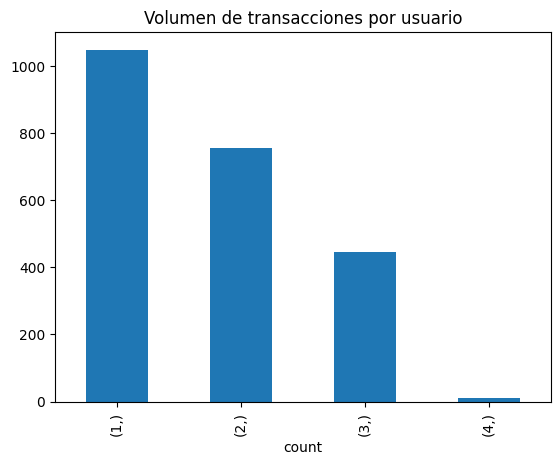

In [13]:
habi_df['id.1'].value_counts().to_frame().value_counts().plot.bar(title='Volumen de transacciones por usuario',)

* Columnas con datos constantes

Las siguientes columnas solo tienen un valor en todo el dataset, por lo que solo introducirian ruido para nuestra clasificacion

Text(0.5, 1.0, 'Distribution is_active')

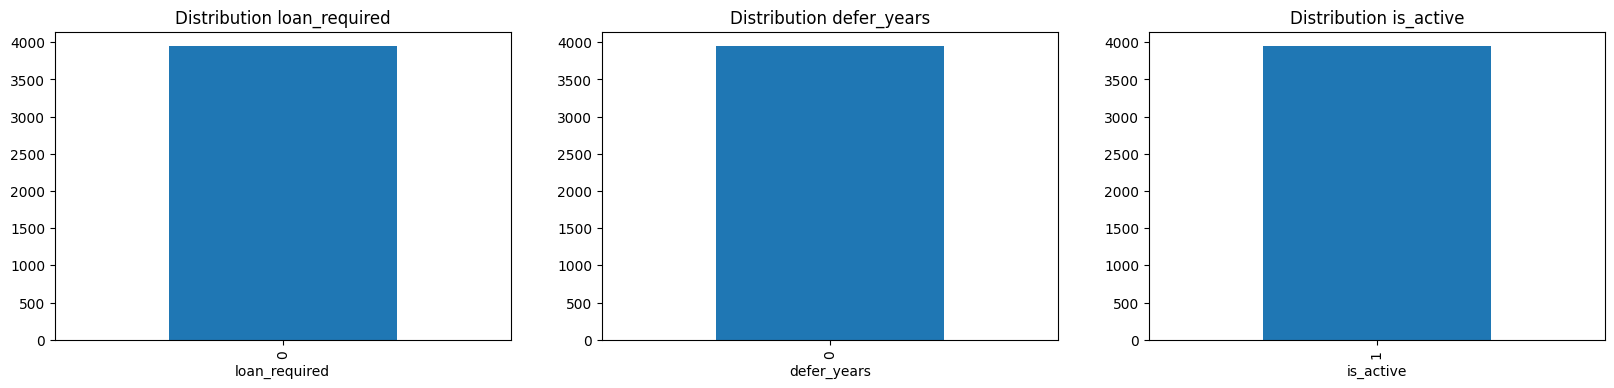

In [14]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
habi_df['loan_required'].value_counts().plot.bar(ax=axes[0] )
axes[0].set_title('Distribution loan_required')

habi_df['defer_years'].value_counts().plot.bar(ax=axes[1])
axes[1].set_title('Distribution defer_years')


habi_df['is_active'].value_counts().plot.bar(ax=axes[2])
axes[2].set_title('Distribution is_active')


## 3. Data Preparation

### Data Selection

In [15]:
ids_columns = ['id','id.1','contact_id']
useless_columns = ['loan_required','defer_years','is_active']
null_columns = ["gender",
    "meta",
    "type_profession_id",
    "type_contract_id",
    "init_occupation_date",
    "company_nit",
    "company_name",
    "company_address",
    "company_phone",
    "company_city_id"
    ]
repeated_columns = ['label','label.1','label.1','activity_code','type_occupation_id']
drop_columns = ids_columns+useless_columns+null_columns+repeated_columns
habi_df = habi_df.drop(columns=drop_columns)

In [16]:
habi_df.to_excel('intermediate_columns.xlsx',index=None)

### Feature Engineering

* Los valor nulos en nuestro dataset tambien nos pueden aportar información util y pueden dar cuenta de un patron en nuestro dataset, 
* Las variables extra_incomes y familiar_debts tienen varios valores en 0, a partir de aqui podemos sacar nuevos features que indiquen si la persona recibio un ingreso extra, y si tiene o no deudas familiares
* Tenemos 2 campos datetime (date_exp_token) y birth_date, de aqui podemos extraer año, mes y dia

<Axes: >

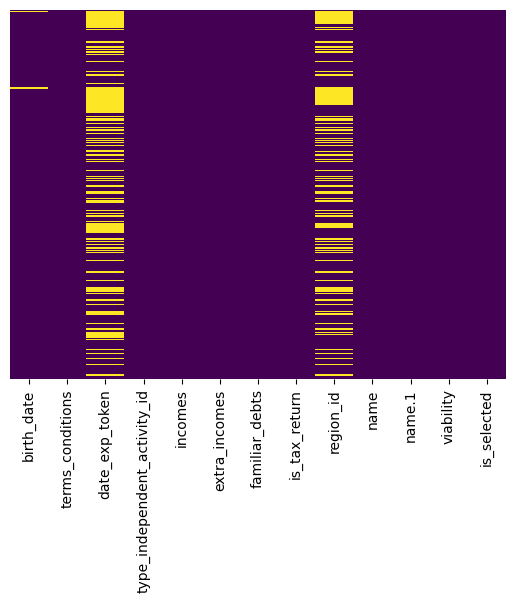

In [17]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [18]:
habi_df['has_extra_incomes'] = (habi_df.extra_incomes==0).astype(int)
habi_df['has_familiar_debts'] = (habi_df.familiar_debts==0).astype(int)
habi_df['has_region_id'] = ~habi_df.region_id.isnull()
habi_df['has_date_exp_token'] = ~habi_df.date_exp_token.isnull()


### Data Cleaning
* birth_date:  Birth date tiene unos solo unos pocos valores nulos, asi que voy a sustituir estos con la mediana
* data_exp_token: Hay varios datos faltantes en esta columna, lo interesante es que los datos respetan un orden cronologico y puedo estos con los datos posteriores. Para no perder la informacion de los datos nulos en esta columna creare una nueva columna 'has_expiration_date'
* region_id: Hay varios datos faltantes en esta columna, mi estrategia sera llenar los datos nulos con 0 para crear una nueva categoria que sea un identificador de nulo. Ademas creare una nueva columna 'has_region_id' para trackear los valores que fueron nulos


In [26]:
# sustituir registros con birth_date nulos
habi_df = habi_df[~habi_df.birth_date.isnull()]
habi_df['birth_date'] = pd.to_datetime(habi_df['birth_date'],format='mixed',errors='coerce')
habi_df = habi_df[~habi_df.birth_date.isnull()]

# Identificar valores nulos en region_id en una nueva columna y completar valores nulos con 0
habi_df['region_id'] = habi_df['region_id'].fillna(0).astype(str)

# Identificar valores nulos en date_exp_token en una nueva columna y completar valores nulos con los valores cercanos
habi_df['date_exp_token'] = habi_df['date_exp_token'].fillna(method='ffill')

<Axes: >

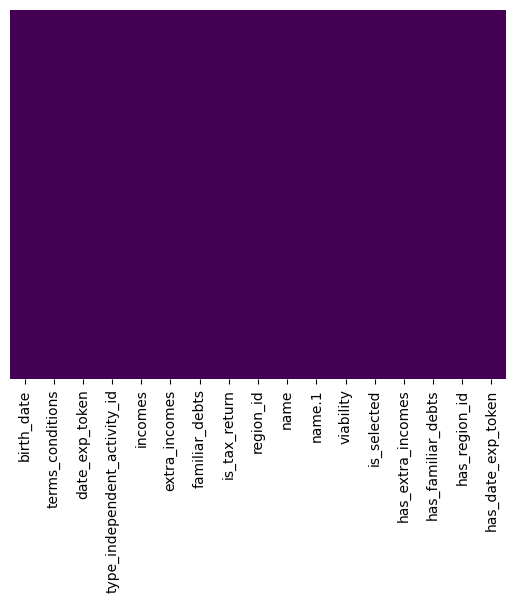

In [27]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Ahora ya no hay valores nulos! 

### Separar columnas de tiempo en años, mes y dia

In [28]:
habi_df['year_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.year
habi_df['month_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.month
habi_df['day_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.day

habi_df['year_birth'] = pd.to_datetime(habi_df['birth_date']).dt.year
habi_df['month_birth'] = pd.to_datetime(habi_df['birth_date']).dt.month
habi_df['day_birth'] = pd.to_datetime(habi_df['birth_date']).dt.day

habi_df = habi_df.drop(columns=['birth_date','date_exp_token'])

In [29]:
habi_df.shape 

(3895, 21)

In [30]:
habi_df.to_excel('habi_clean.xlsx',index=None)

In [194]:
habi_df= pd.read_excel('habi_clean.xlsx')
habi_df.shape

(3895, 21)

In [195]:
habi_df['age'] = habi_df['year_birth'].max() -habi_df['year_birth']
#habi_df = habi_df.drop(columns=['year_birth','month_birth','day_birth'])

In [196]:
def age_section(age):

    if age < 20:
        return 'less 20'
    elif age < 40:
        return 'less 40'
    else:
        return 'more 40'

habi_df['age_section'] = habi_df['age'].apply(age_section)

In [197]:
# Get the frequency counts of each name
name_counts = habi_df['region_id'].value_counts()

# Identify the names with frequency less than 15
unfrequent_names = name_counts[name_counts < 15].index

# Replace the unfrequent names with -1
habi_df['region_id'] = habi_df['region_id'].replace(unfrequent_names, -1).astype(str)

## 4. Modeling

### Oversampling

Nuestro dataset es imbalanceado, para la ello vamos a aplicar oversampling

In [198]:
habi_df = habi_df.sample(frac=1,random_state=44)

# amount of no viability classes 1246 rows.
viability_df = habi_df.loc[habi_df['viability'] == 1][:1230]
non_viability_df = habi_df.loc[habi_df['viability'] == 0]

normal_distributed_df = pd.concat([viability_df, non_viability_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

(2460, 23)

### Distribucion variable objetivo vs variables categoricas

In [199]:
binary_cols = ['terms_conditions','is_tax_return','is_selected','has_region_id','has_date_exp_token']
ohe_cols = ['type_independent_activity_id','region_id','name','name.1','year_exp_token','year_birth','age_section']
numerical_cols = ['incomes','extra_incomes','familiar_debts',] #'age'
categorical = binary_cols+ ohe_cols
target ='viability'


terms_conditions


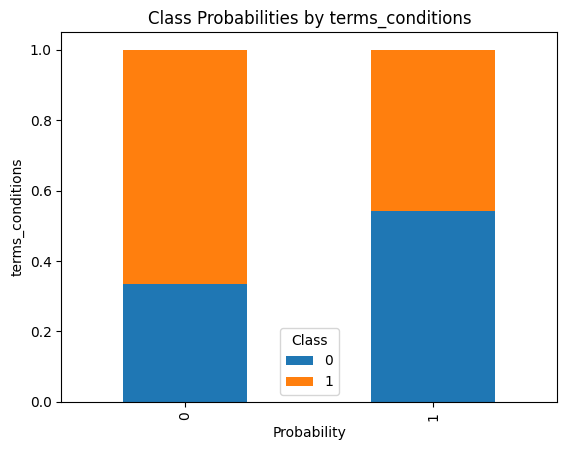

is_tax_return


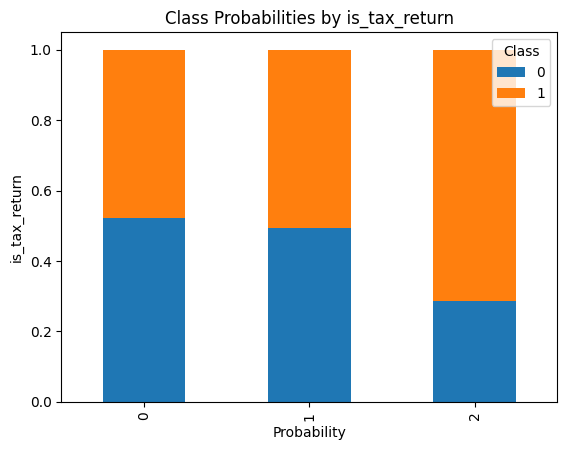

is_selected


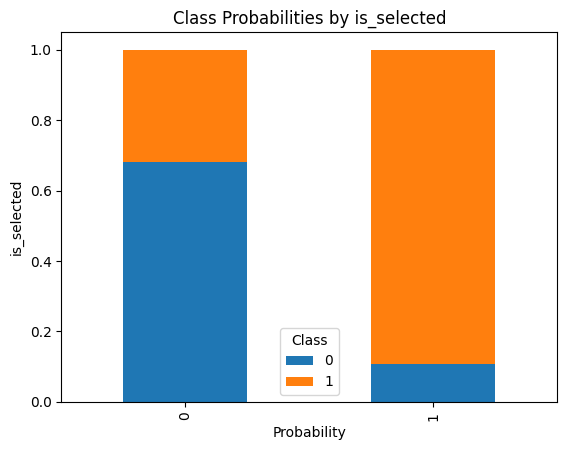

has_region_id


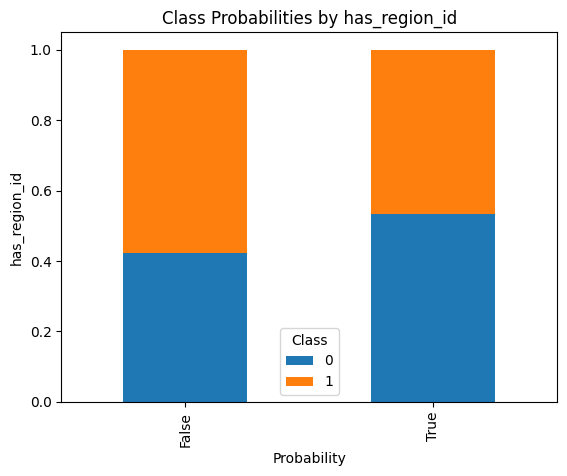

has_date_exp_token


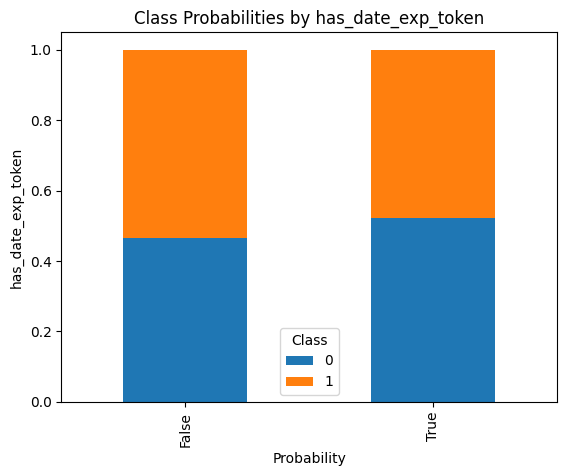

type_independent_activity_id


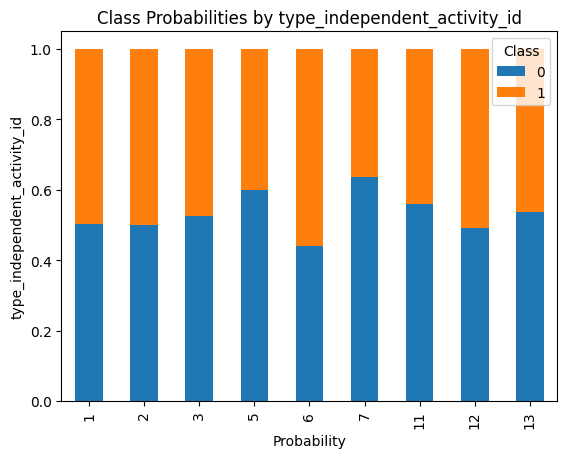

region_id


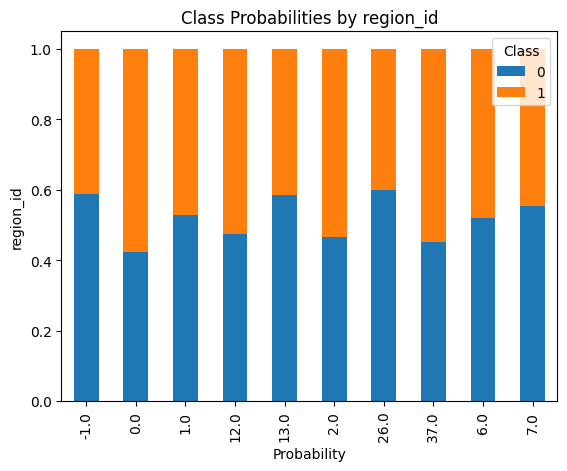

name


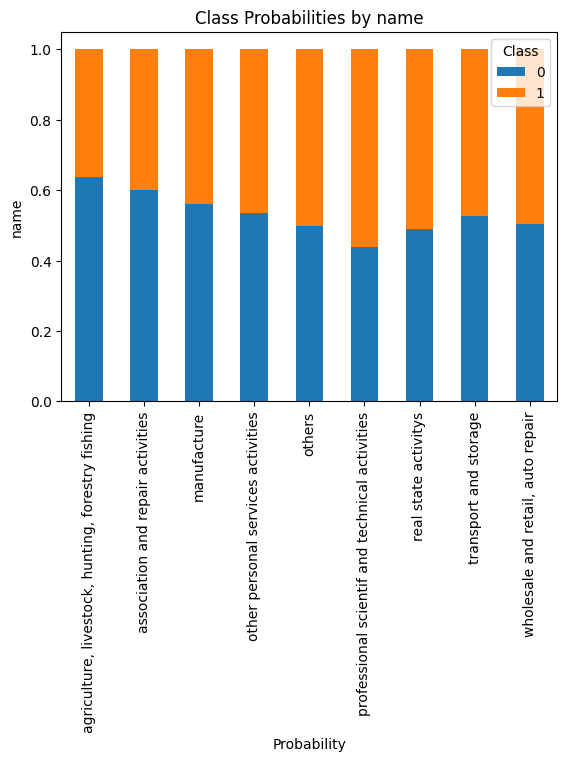

name.1


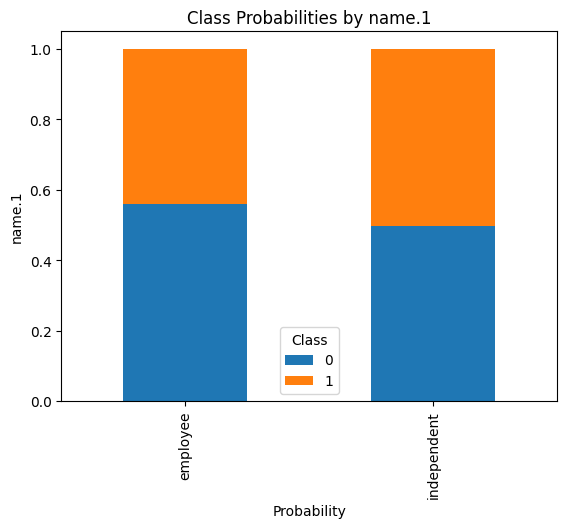

year_exp_token


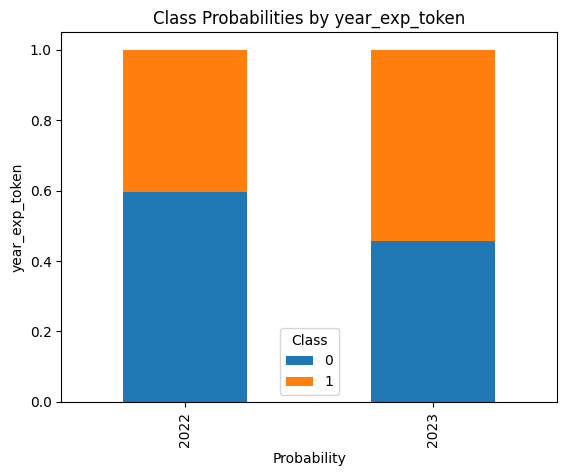

year_birth


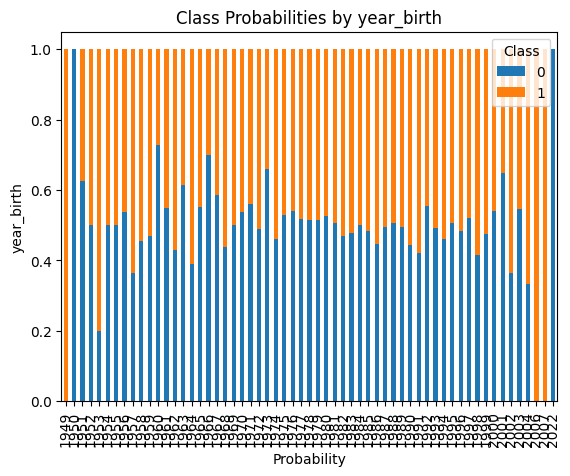

age_section


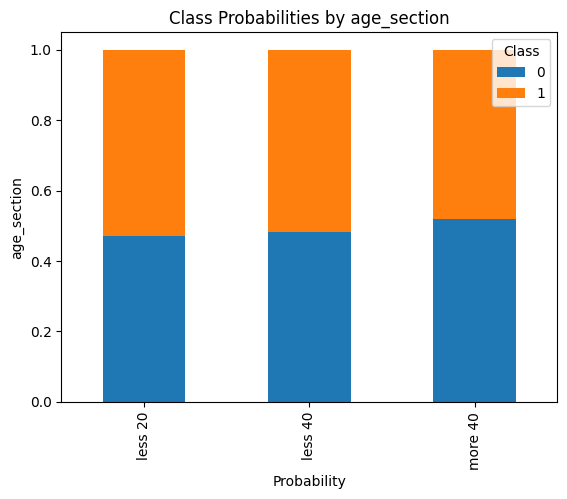

In [200]:
def proba_plot(df:pd.DataFrame,feature:str):
    # Calculate probabilities
    class_counts = df.groupby([feature, target]).size().unstack()
    class_probs = class_counts.div(class_counts.sum(axis=1), axis=0)

    # Plotting
    class_probs.plot(kind='bar', stacked=True)
    plt.xlabel('Probability')
    plt.ylabel(feature)
    plt.title(f'Class Probabilities by {feature}')
    plt.legend(title='Class')
    plt.show()
    

for c in categorical:
    print(c)
    proba_plot(new_df,c)

In [201]:
out_df = new_df.copy()
out_df['incomes'] = np.log1p(out_df['incomes'])
out_df['extra_incomes'] = np.log1p(out_df['extra_incomes'])
out_df['familiar_debts'] = np.log1p(out_df['familiar_debts'])

(2422, 23)

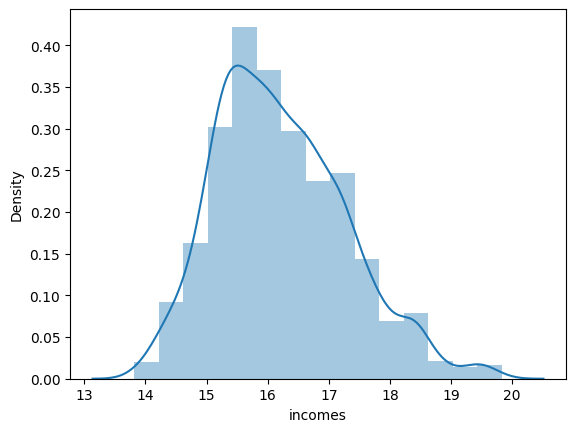

In [202]:

q25, q75 = out_df['incomes'].quantile(0.25),out_df['incomes'].quantile(0.75)
iqr = q75 - q25
cut_off = iqr * 2
lower, upper = q25 - cut_off, q75 + cut_off

out_df = out_df[(out_df['incomes']>lower)&(out_df['incomes']<upper)]   

sns.distplot(out_df['incomes'],bins=15)

out_df.shape

-19.34883348913049 32.248055815217484


<Axes: xlabel='familiar_debts', ylabel='Density'>

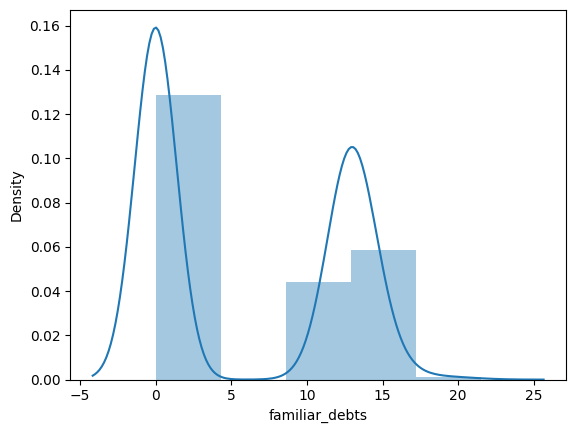

In [203]:

q25, q75 = out_df['familiar_debts'].quantile(0.25),out_df['familiar_debts'].quantile(0.75)

iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, upper)

out_df = out_df[(out_df['familiar_debts']>lower)&(out_df['familiar_debts']<upper)] 


sns.distplot(out_df['familiar_debts'],bins=5)


In [204]:
out_df[categorical].shape

(2422, 12)

In [205]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series,out_df['viability'])


mi = out_df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

is_selected                     0.157200
terms_conditions                0.015165
year_birth                      0.008652
year_exp_token                  0.007936
region_id                       0.007363
has_region_id                   0.004748
type_independent_activity_id    0.003234
name                            0.003234
has_date_exp_token              0.001475
age_section                     0.000637
is_tax_return                   0.000602
name.1                          0.000217
dtype: float64

In [108]:
out_df.columns

Index(['terms_conditions', 'type_independent_activity_id', 'incomes',
       'extra_incomes', 'familiar_debts', 'is_tax_return', 'region_id', 'name',
       'name.1', 'viability', 'is_selected', 'has_extra_incomes',
       'has_familiar_debts', 'has_region_id', 'has_date_exp_token',
       'year_exp_token', 'month_exp_token', 'day_exp_token', 'year_birth',
       'month_birth', 'day_birth', 'age'],
      dtype='object')

In [226]:
#'day_exp_token'
ohe_cols = ['type_independent_activity_id','region_id','name','name.1','year_exp_token','age_section']

ohe = pd.get_dummies(out_df[ohe_cols].astype(str)).astype(int)
ohe

,type_independent_activity_id_1,type_independent_activity_id_11,type_independent_activity_id_12,type_independent_activity_id_13,type_independent_activity_id_2,type_independent_activity_id_3,type_independent_activity_id_5,type_independent_activity_id_6,type_independent_activity_id_7,region_id_-1.0,...,name_real state activitys,name_transport and storage,"name_wholesale and retail, auto repair",name.1_employee,name.1_independent,year_exp_token_2022,year_exp_token_2023,age_section_less 20,age_section_less 40,age_section_more 40
690,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
523,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
2278,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
2811,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
2502,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1611,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1289,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
2080,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1


In [227]:
merge = out_df[['terms_conditions','incomes','extra_incomes','familiar_debts','is_tax_return',
                'viability','is_selected','has_extra_incomes', 'has_familiar_debts',
                'has_region_id', 'has_date_exp_token']]
merge = pd.concat([merge.reset_index(drop=True),ohe.reset_index(drop=True)],axis=1)

# Train

In [228]:

# Extract feature and target arrays
X, y = merge.drop('viability', axis=1), merge['viability']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=4, stratify=y)



In [229]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


# Define the objective function for Optuna
def objective(trial, xtrain,ytrain,xval,yval):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 10),
        'random_state': 42
    }
    
    # Create the XGBoost classifier
    xgb_cl = xgb.XGBClassifier(**params)
    
    # Fit the classifier
    xgb_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = xgb_cl.predict(xval)
    
    # Calculate roc_auc_score
    score = f1_score(yval, preds, average='weighted')
    #roc_auc_score(yval, preds)
    
    return score


def objective_cv(trial):
    
    # Get the MNIST dataset.
    skf = StratifiedKFold(n_splits=4)
    score_list = []
    
    for train_index, test_index in skf.split(X_test, y_test):
        x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
        score = objective(trial, x_train_fold,y_train_fold, x_val_fold,y_val_fold)
        score_list.append(score)
    return np.mean(score_list)

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=30,n_jobs=8)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

[I 2023-06-04 00:29:09,625] A new study created in memory with name: no-name-9d7349d3-6eee-4b5a-97fe-cdbfd6b67ba8
[I 2023-06-04 00:29:10,002] Trial 2 finished with value: 0.346128039641319 and parameters: {'max_depth': 16, 'learning_rate': 0.010478912639321769, 'subsample': 0.7, 'colsample_bytree': 0.9, 'n_estimators': 39, 'gamma': 0.04959394090030278, 'reg_alpha': 4.811653883496367, 'reg_lambda': 8.599334020158857, 'min_child_weight': 9.368800868801229, 'scale_pos_weight': 3.637563146563134}. Best is trial 2 with value: 0.346128039641319.
[I 2023-06-04 00:29:11,670] Trial 1 finished with value: 0.7558422563793284 and parameters: {'max_depth': 12, 'learning_rate': 0.013071273802306207, 'subsample': 0.6, 'colsample_bytree': 0.6, 'n_estimators': 423, 'gamma': 0.7519386327590236, 'reg_alpha': 8.087365858892428, 'reg_lambda': 8.390745485893001, 'min_child_weight': 8.889266675045258, 'scale_pos_weight': 1.1339975040913042}. Best is trial 1 with value: 0.7558422563793284.
[I 2023-06-04 00:29

Best Parameters: {'max_depth': 12, 'learning_rate': 0.013071273802306207, 'subsample': 0.6, 'colsample_bytree': 0.6, 'n_estimators': 423, 'gamma': 0.7519386327590236, 'reg_alpha': 8.087365858892428, 'reg_lambda': 8.390745485893001, 'min_child_weight': 8.889266675045258, 'scale_pos_weight': 1.1339975040913042}
Best ROC AUC Score: 0.7558422563793284


In [230]:
# Create the best classifier with the best parameters
best_classifier = xgb.XGBClassifier(**best_params)

# Fit the best classifier on the entire dataset
best_classifier.fit(X_train, y_train)

preds = best_classifier.predict(X_test)
    
    # Calculate roc_auc_score
score = roc_auc_score(y_test, preds)

score

0.7749039213685679

[Text(0.5, 58.7222222222222, 'Predicted'),
 Text(70.72222222222221, 0.5, 'Actual')]

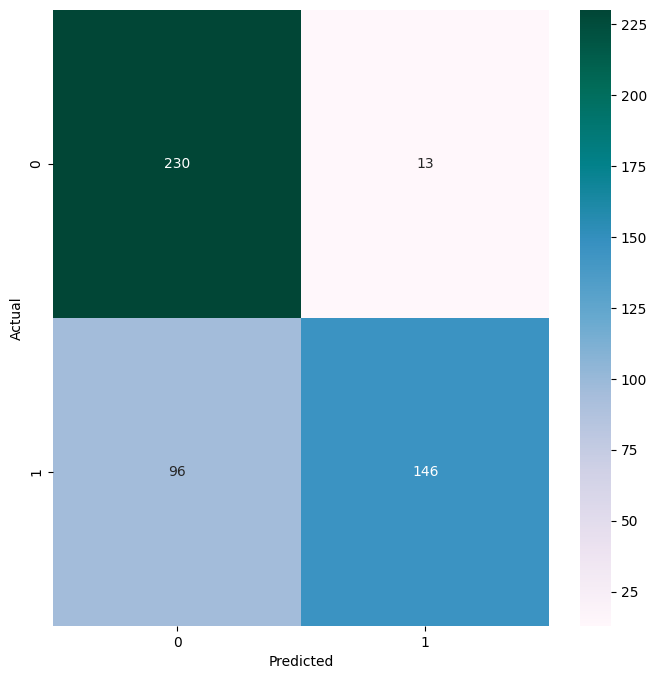

In [231]:

cm = confusion_matrix(y_test, preds,labels=[0,1])
cm_df = pd.DataFrame(cm ,columns=['0','1'],index=['0','1'])
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')

[Text(0.5, 58.7222222222222, 'Predicted'),
 Text(70.72222222222221, 0.5, 'Actual')]

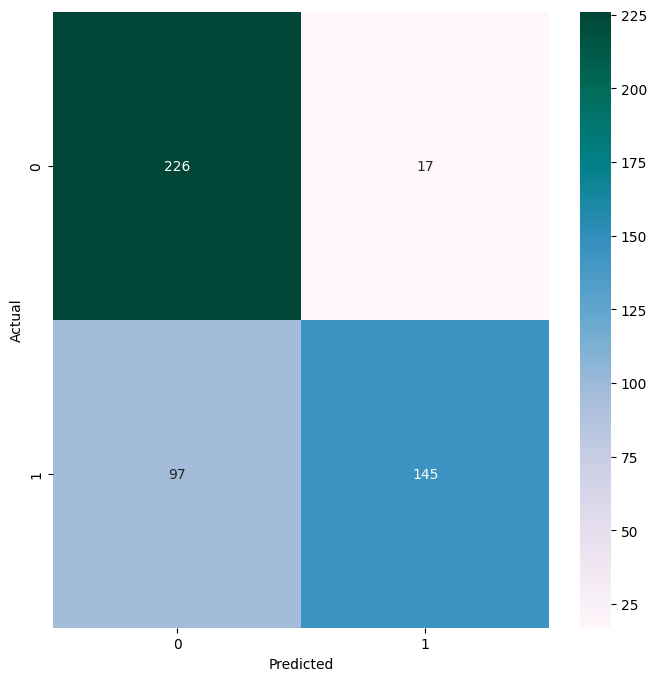

In [216]:

cm = confusion_matrix(y_test, preds,labels=[0,1])
cm_df = pd.DataFrame(cm ,columns=['0','1'],index=['0','1'])
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')

In [232]:
print(classification_report(y_test, preds, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.71      0.95      0.81       243
           1       0.92      0.60      0.73       242

    accuracy                           0.78       485
   macro avg       0.81      0.77      0.77       485
weighted avg       0.81      0.78      0.77       485



In [233]:
x = best_classifier.predict_proba(X_test)[:,1]
low = 0.4
top = 0.6
print(((x>low) & (x<top)).sum())
print((x>top).sum())
print((x<low).sum())

77
159
249


# Feature importance 

In [234]:
# Get feature importances
importances = best_classifier.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

feature_importances.head(10)

,Feature,Importance
5,is_selected,0.515948
7,has_familiar_debts,0.048558
0,terms_conditions,0.045998
40,year_exp_token_2022,0.032838
24,region_id_2.0,0.023876
41,year_exp_token_2023,0.023484
3,familiar_debts,0.021280
9,has_date_exp_token,0.020568
21,region_id_1.0,0.017310
36,name_transport and storage,0.016683


In [236]:
top_features = feature_importances[feature_importances['Importance']>0.013]['Feature'].to_list()
top_features

['is_selected',
 'has_familiar_debts',
 'terms_conditions',
 'year_exp_token_2022',
 'region_id_2.0',
 'year_exp_token_2023',
 'familiar_debts',
 'has_date_exp_token',
 'region_id_1.0',
 'name_transport and storage',
 'age_section_more 40',
 'type_independent_activity_id_3',
 'type_independent_activity_id_12']

In [239]:

partial = merge[top_features+['viability']]
# Extract feature and target arrays
X, y = partial.drop('viability', axis=1), partial['viability']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=4, stratify=y)


In [240]:


# Define the objective function for Optuna
def objective(trial, xtrain,ytrain,xval,yval):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 10),
        'random_state': 42
    }
    
    # Create the XGBoost classifier
    xgb_cl = xgb.XGBClassifier(**params)
    
    # Fit the classifier
    xgb_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = xgb_cl.predict(xval)
    
    # Calculate roc_auc_score
    score = f1_score(yval, preds, average='weighted')
    
    return score


def objective_cv(trial):
    
    # Get the MNIST dataset.
    skf = StratifiedKFold(n_splits=5)
    score_list = []
    
    for train_index, test_index in skf.split(X_test, y_test):
        x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
        score = objective(trial, x_train_fold,y_train_fold, x_val_fold,y_val_fold)
        score_list.append(score)
    return np.mean(score_list)

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=100,n_jobs=-8)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

[I 2023-06-04 00:32:24,754] A new study created in memory with name: no-name-0e5630fa-135e-4b9f-ad56-1ab00e71a0ea
[I 2023-06-04 00:32:24,915] Trial 0 finished with value: 0.751766519059479 and parameters: {'max_depth': 5, 'learning_rate': 0.07037526391535266, 'subsample': 0.9, 'colsample_bytree': 0.8, 'n_estimators': 78, 'gamma': 0.40027015202405214, 'reg_alpha': 9.591054655906863, 'reg_lambda': 8.92174639081816, 'min_child_weight': 5.510516352384234, 'scale_pos_weight': 1.4291368144526984}. Best is trial 0 with value: 0.751766519059479.
[I 2023-06-04 00:32:25,022] Trial 1 finished with value: 0.5183200216780454 and parameters: {'max_depth': 10, 'learning_rate': 0.058129117193247704, 'subsample': 0.9, 'colsample_bytree': 0.6, 'n_estimators': 41, 'gamma': 0.6905018506108996, 'reg_alpha': 9.134072506175864, 'reg_lambda': 9.9165909355167, 'min_child_weight': 1.074575209933668, 'scale_pos_weight': 1.8600760232000002}. Best is trial 0 with value: 0.751766519059479.
[I 2023-06-04 00:32:25,53

Best Parameters: {'max_depth': 15, 'learning_rate': 0.019069086525660105, 'subsample': 0.9, 'colsample_bytree': 0.9, 'n_estimators': 317, 'gamma': 0.3485731639438574, 'reg_alpha': 4.729338879238378, 'reg_lambda': 3.0733017917090866, 'min_child_weight': 8.62879176658597, 'scale_pos_weight': 1.0468584562606698}
Best ROC AUC Score: 0.7556966405841334


In [241]:
# Create the best classifier with the best parameters
best_classifier = xgb.XGBClassifier(**best_params)

# Fit the best classifier on the entire dataset
best_classifier.fit(X_train, y_train)

preds = best_classifier.predict(X_test)
    
    # Calculate roc_auc_score
score = roc_auc_score(y_test, preds)

score

0.7749039213685679

In [242]:
y_pred_proba = best_classifier.predict_proba(X_test)[::,1]
preds = (y_pred_proba>0.5).astype(int)

print(classification_report(y_test, preds, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.71      0.95      0.81       243
           1       0.92      0.60      0.73       242

    accuracy                           0.78       485
   macro avg       0.81      0.77      0.77       485
weighted avg       0.81      0.78      0.77       485



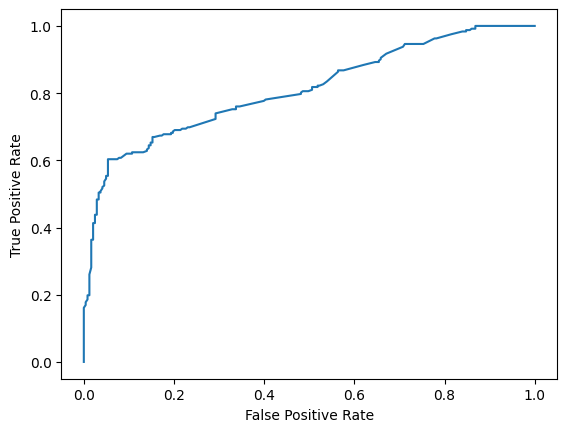

In [243]:
from sklearn import metrics

y_pred_proba = best_classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [248]:
from sklearn.linear_model import LogisticRegression

# Define the objective function for Optuna
def objective(trial, xtrain, ytrain, xval, yval):
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'C': trial.suggest_loguniform('C', 0.001, 100.0),
        'solver': trial.suggest_categorical('solver', [ 'liblinear', 'saga']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 10000),
        'random_state': 42
    }
    
    # Create the Logistic Regression classifier
    lr_cl = LogisticRegression(**params)
    
    # Fit the classifier
    lr_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = lr_cl.predict(xval)
    
    # Calculate f1-score
    score = f1_score(yval, preds, average='weighted')
    
    return score


def objective_cv(trial):
    
    skf = StratifiedKFold(n_splits=4)
    score_list = []
    
    for train_index, test_index in skf.split(X_test, y_test):
        x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
        score = objective(trial, x_train_fold, y_train_fold, x_val_fold, y_val_fold)
        score_list.append(score)
    
    return np.mean(score_list)


# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=100, n_jobs=8)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)

[I 2023-06-04 00:46:06,696] A new study created in memory with name: no-name-8d5e1fc4-dfd0-4041-88ac-3064b47c50ac
[I 2023-06-04 00:46:06,846] Trial 1 finished with value: 0.7558422563793284 and parameters: {'penalty': 'l1', 'C': 0.18037630175971262, 'solver': 'liblinear', 'fit_intercept': False, 'max_iter': 8853}. Best is trial 1 with value: 0.7558422563793284.
[I 2023-06-04 00:46:06,849] Trial 2 finished with value: 0.7446678490126963 and parameters: {'penalty': 'l2', 'C': 0.05410220499771854, 'solver': 'liblinear', 'fit_intercept': True, 'max_iter': 6098}. Best is trial 1 with value: 0.7558422563793284.
[I 2023-06-04 00:46:06,862] Trial 6 finished with value: 0.7475896711021992 and parameters: {'penalty': 'l2', 'C': 11.216957774867948, 'solver': 'liblinear', 'fit_intercept': False, 'max_iter': 6463}. Best is trial 1 with value: 0.7558422563793284.
[I 2023-06-04 00:46:06,868] Trial 5 finished with value: 0.6903294059714088 and parameters: {'penalty': 'l2', 'C': 0.02306752972615534, 's

Best Parameters: {'penalty': 'l2', 'C': 0.11273860046750195, 'solver': 'saga', 'fit_intercept': True, 'max_iter': 8246}
Best F1-Score: 0.7584862626383999


[Text(0.5, 58.7222222222222, 'Predicted'),
 Text(70.72222222222221, 0.5, 'Actual')]

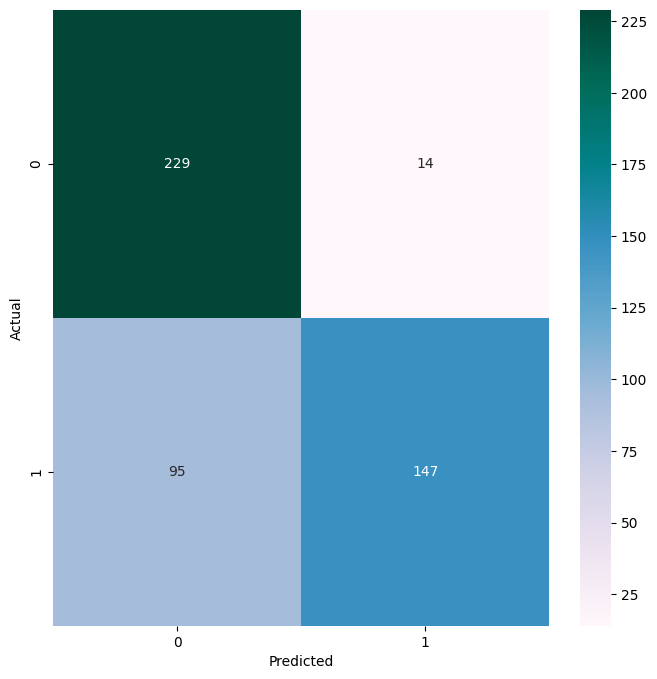

In [249]:
best_classifier = LogisticRegression(**best_params)
best_classifier.fit(X_train, y_train)
preds = best_classifier.predict(X_test)


cm = confusion_matrix(y_test, preds,labels=[0,1])
cm_df = pd.DataFrame(cm ,columns=['0','1'],index=['0','1'])
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')

In [250]:
from sklearn.svm import SVC

# Define the objective function for Optuna
def objective(trial, xtrain, ytrain, xval, yval):
    params = {
        'C': trial.suggest_loguniform('C', 0.001, 100.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'coef0': trial.suggest_uniform('coef0', -1.0, 1.0),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
        'probability': trial.suggest_categorical('probability', [True, False]),
        'random_state': 42
    }
    
    # Create the SVM classifier
    svm_cl = SVC(**params)
    
    # Fit the classifier
    svm_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = svm_cl.predict(xval)
    
    # Calculate f1-score
    score = f1_score(yval, preds, average='weighted')
    
    return score


# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=30, n_jobs=8)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)

[I 2023-06-04 00:51:24,049] A new study created in memory with name: no-name-313cced0-5957-4d21-a1eb-3815709f51ed
[I 2023-06-04 00:51:24,156] Trial 7 finished with value: 0.4801546113572458 and parameters: {'C': 50.371142705834025, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale', 'coef0': -0.7288773461090106, 'shrinking': False, 'probability': False}. Best is trial 7 with value: 0.4801546113572458.
[I 2023-06-04 00:51:24,163] Trial 0 finished with value: 0.7172711190210455 and parameters: {'C': 0.30004787813756406, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': 0.9212037681430012, 'shrinking': True, 'probability': False}. Best is trial 0 with value: 0.7172711190210455.
[I 2023-06-04 00:51:24,220] Trial 4 finished with value: 0.5783801371231679 and parameters: {'C': 0.007489265135262983, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto', 'coef0': -0.48859894058084796, 'shrinking': False, 'probability': True}. Best is trial 0 with value: 0.7172711190210455.
[I 2023-06-04 00:51:24

Best Parameters: {'C': 2.8382132009714307, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale', 'coef0': 0.772143128896541, 'shrinking': True, 'probability': True}
Best F1-Score: 0.7574184143207325


[Text(0.5, 58.7222222222222, 'Predicted'),
 Text(70.72222222222221, 0.5, 'Actual')]

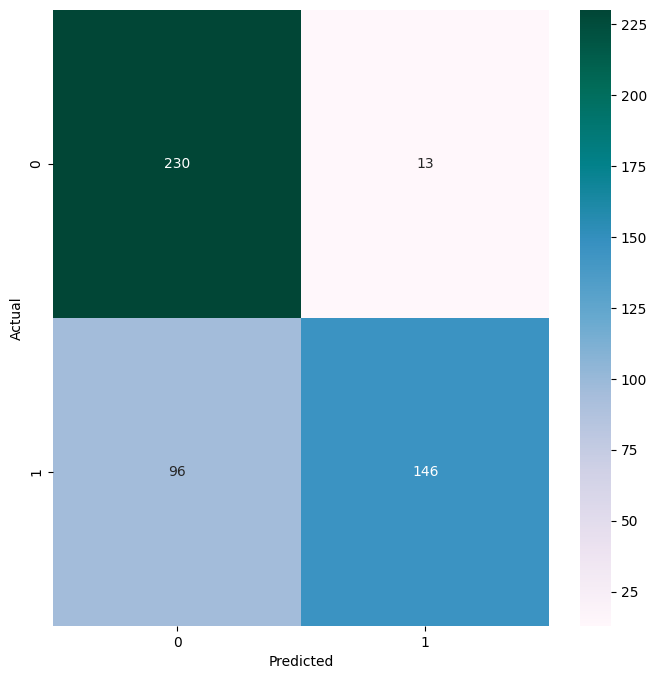

In [252]:
best_classifier = SVC(**best_params)
best_classifier.fit(X_train, y_train)
preds = best_classifier.predict(X_test)


cm = confusion_matrix(y_test, preds,labels=[0,1])
cm_df = pd.DataFrame(cm ,columns=['0','1'],index=['0','1'])
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')